<a href="https://colab.research.google.com/github/bishalpaudel/SentimentAnalysis/blob/master/sentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/AI/SentimentAnalysis/train.tsv", delimiter="\t")
df_test = pd.read_csv("/content/drive/My Drive/AI/SentimentAnalysis/test.tsv", delimiter="\t")

In [ ]:
review_train = df_train['Phrase']
label_train = df_train['Sentiment']

**2) Data Processing — convert to lower case**

In [ ]:
review_train = review_train.str.lower()

**3) Data Processing — remove punctuation**


In [ ]:
import string
reviews_split = review_train.str.replace('[{}]'.format(string.punctuation), '')

**5) Tokenize — Create Vocab to Int mapping dictionary**


In [ ]:
from collections import Counter
all_text2 = ' '.join(reviews_split);

# Creates a list of words
words = all_text2.split()

# Make a word count list
count_words = Counter(words)

total_words = len(words)

# Get the most used words
sorted_words = count_words.most_common(total_words)



In [ ]:
# Why i + 1: In order to start from 1 index, and not 0.
# Integer Encoding:
vocab_to_int = {w:i+1 for i, (w, c) in enumerate(sorted_words)}

**6) Tokenize — Encode the words:** Convert all the review text to integer based on integer-words

In [ ]:
reviews_int = []
for review in reviews_split:
  r = [vocab_to_int[w] for w in review.split()]
  reviews_int.append(r)

**7) Tokenize — Encode the labels**


In [ ]:
import numpy as np
encoded_labels = [1 if label>1 else 0 for label in label_train]
encoded_labels = np.array(encoded_labels)

**8) Analyze Reviews Length**


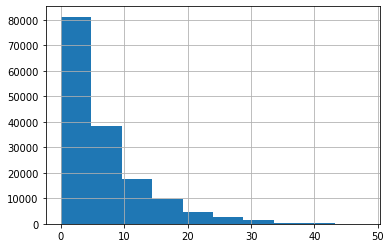

count    156060.000000
mean          6.716000
std           6.435939
min           0.000000
25%           2.000000
50%           4.000000
75%           9.000000
max          48.000000
dtype: float64

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()

pd.Series(reviews_len).describe()

**9) Removing Outliers — Getting rid of extremely long or short reviews**


In [ ]:
reviews_int = [reviews_int[i] for i, l in enumerate(reviews_len) if l > 0]
encoded_labels = [encoded_labels[i] for i, l in enumerate(reviews_len) if l > 0]

**10) Padding / Truncating the remaining data**


In [ ]:
def pad_features(reviews_int, seq_length):
  features = np.zeros((len(reviews_int), seq_length), dtype=int)

  for i, review in enumerate(reviews_int):
    review_len = len(review)

    # Pad with Zeros
    if review_len < seq_length:
      zeros = list(np.zeros(seq_length - review_len))
      new = zeros + review
    # Truncate
    elif reviews_len > seq_length:
      new = review[0:seq_length]

    features[i,:] = np.array(new)
  return features


In [ ]:
features = pad_features(reviews_int, 200)

**11) Training, Validation, Test Dataset Split**


In [ ]:
split_frac = 0.8
len_feat = len(features)
train_x = features[0 : int(split_frac * len_feat)]
train_y = encoded_labels[0 : int(split_frac * len_feat)]

remaining_x = features[int(split_frac * len_feat) : ]
remaining_y = encoded_labels[int(split_frac * len_feat) : ]
 
valid_x = remaining_x[0 : int(len(remaining_x) * 0.5)]
valid_y = remaining_y[0 : int(len(remaining_y) * 0.5)]

test_x = remaining_x[int(len(remaining_x) * 0.5) : ]
test_y = remaining_y[int(len(remaining_y) * 0.5) : ]

**12) Dataloaders and Batching**


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.from_numpy(np.asarray(train_x)), torch.from_numpy(np.asarray(train_y)))
valid_data = TensorDataset(torch.from_numpy(np.asarray(valid_x)), torch.from_numpy(np.asarray(valid_y)))
test_data = TensorDataset(torch.from_numpy(np.asarray(test_x)), torch.from_numpy(np.asarray(test_y)))

batch_size = 50

train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size)
valid_loader = DataLoader(valid_data, shuffle = True, batch_size = batch_size)
test_loader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

In [ ]:
train_on_gpu = True
data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()


print('sample input size: ', sample_x.size())
print('sample input \n', sample_x)
print()
print('sample label size: ', sample_y.size())
print('sample label \n', sample_y)


sample input size:  torch.Size([50, 200])
sample input 
 tensor([[   0,    0,    0,  ...,    2, 2882,  187],
        [   0,    0,    0,  ...,    7,    1, 3839],
        [   0,    0,    0,  ...,  133,  173,  116],
        ...,
        [   0,    0,    0,  ..., 4310,   14,  406],
        [   0,    0,    0,  ...,    0,  370, 1921],
        [   0,    0,    0,  ...,  145, 6547,  214]])

sample label size:  torch.Size([50])
sample label 
 tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1])


**14) Define the Model Class**


In [ ]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
    super().__init__()
    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
    self.dropout = nn.Dropout(0.3)

    self.fc = nn.Linear(hidden_dim, output_size)
    self.sig = nn.Sigmoid()

  def forward(self, x, hidden):
    batch_size = x.size(0)

    # Passing x though embedding layer
    embeds = self.embedding(x)

    # Passing x though LSTM layer
    lstm_out, hidden = self.lstm(embeds, hidden)

    # Stack up LSTM outputs
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    # Passing output though dropout layer: in order to regularize
    out = self.dropout(lstm_out)

    # Passing x though fully connected layer, in order to reduce dimension to linear
    out = self.fc(out)

    # Passing fully connected output through sigmoid in order to contain output between 0 and 1
    sig_out = self.sig(out)

    sig_out = sig_out.view(batch_size, -1)
    sig_out = sig_out[:, -1]

    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    weight = next(self.parameters()).data

    if (train_on_gpu):
      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
      
    return hidden




**15) Training the Network**


- **Instantiate the network**


In [ ]:
# +1 for 0 padding
vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)


SentimentLSTM(
  (embedding): Embedding(16416, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


- **Training Loop**

In [ ]:
lr = 0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

epochs = 4
counter = 0
print_every = 100
clip = 5

if (train_on_gpu):
  net.cuda()

net.train()

for e in range(epochs):
  # Initialize hidden state
  h = net.init_hidden(batch_size)

  for inputs, labels in train_loader:
    counter += 1;
    if (inputs.size()[0] != 50):
      continue
    # if train_on_gpu:
    inputs, labels = inputs.cuda(), labels.cuda()

    h = tuple([each.data for each in h])

    net.zero_grad()

    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()

    # `clip_grad_norm` helps prevent exploding gradient problem in RNNs/LSTMs
    nn.utils.clip_grad_norm(net.parameters(), clip)
    optimizer.step()

    if counter % print_every == 0:
      # Get validation loss
      val_h = net.init_hidden(batch_size)
      val_losses = []
      net.eval()

      for inputs_v, labels_v in valid_loader:
        if (inputs_v.size()[0] != 50):
          continue

        val_h = tuple([each.data for each in val_h])

        # if (train_on_gpu):
        #   inputs_v, labels = inputs_v.cuda(), labels_v.cuda()

        # print('inputs_v.size()')
        # print(inputs_v.size()[0])
        # print('inputs_v.size()[0] == 50')
        # print(inputs_v.size()[0] == 50)
        # print('val_h.count')
        # print(val_h.count)
        
        inputs_v = inputs_v.type(torch.LongTensor)
        output_valid, val_h = net(inputs_v, val_h)

        val_loss = criterion(output_valid.squeeze(), labels_v.float())

        val_losses.append(val_loss.item())
      
      net.train()
      print("Epoch: {}/{}...".format(e+1, epochs),
            "Step: {}...".format(counter),
            "Loss: {:.6f}".format(loss.item()),
            "Val loss: {:.6f}".format(np.mean(val_losses)))

RuntimeError: ignored

**16) Testing**

- **On Test Data**

In [ ]:
test_losses = []
num_correct = 0

h = net.init_hidden(batch_size)

net.eval()

for inputs, labels in test_loader:
  if (inputs.size()[0] != 50):
    continue
  h = tuple([each.data for each in h])

  if(train_on_gpu):
    inputs, labels = inputs.cuda(), labels.cuda()

  inputs = inputs.type(torch.LongTensor)
  output, h = net(inputs, h)

  test_loss = criterion(output.squeeze(), labels.float())
  test_losses.append(test_loss.item())

  # Convert output probabilities to predicted class (0 or 1)
  pred = torch.round(output.squeeze())

  # Compare predictions to true label
  correct_tensor = pred.eq(labels.float().view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  num_correct += np.sum(correct)

# Average test loss
print("Test Loss: {:.3f}".format(np.mean(test_losses)))

# Accuracy over all test data
test_acc = num_correct / len(test_loader.dataset)
print("Test Accuracy: {:.3f}".format(test_acc))
